In [27]:
import sys
# sys.path.append('....')
# sys.path.append('lib/src/')
# sys.path.append('riemannian_random_walk.models/')
sys.path.append('../../')
sys.path.append('../../lib/src/')
sys.path.append('../../TopographicVAE-master')

import torch
from torch import nn
from itertools import islice
import os
import numpy as np
from matplotlib import pyplot as plt


from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_ColorMNIST, Decoder_ColorMNIST,Encoder_Chairs, Decoder_Chairs, My_MaskedDataset
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler
from lib.src.pythae.trainers.training_callbacks import WandbCallback


from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling


from riemannian_random_walk.models.generation import hmc_manifold_sampling, random_walk_batch


def plot_sequence(grid, color=False):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()

def extract_dataset(loader, c = 3, h = 28, w = 28):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        data = data.reshape(-1, c, h, w)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset
    

%reload_ext autoreload
%autoreload 2
!nvidia-smi

Thu Aug  1 16:10:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   36C    P8             10W /   70W |     119MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([7000, 1, 64, 64])


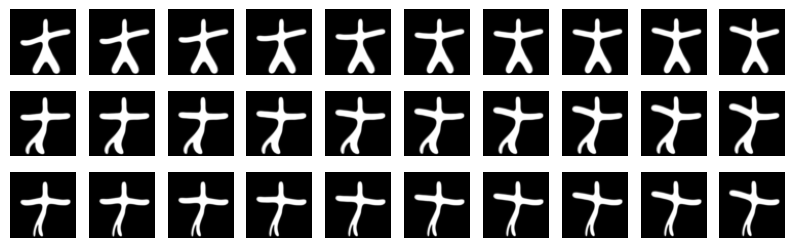

In [42]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load('starmen_data.pt')[:700].unsqueeze(2).reshape(-1, 1, 64, 64)
eval_data = torch.load('starmen_data.pt')[700:900].unsqueeze(2).reshape(-1, 1, 64, 64)
test_data = torch.load('starmen_data.pt')[900:].unsqueeze(2).reshape(-1, 1, 64, 64)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

plot_sequence(train_data[:30].reshape(3, 10, 1, 64, 64), color=False)

In [62]:
input_dim = (1, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3

##############


latent_dim = new_num_channels* (input_dim[1] // f) * (input_dim[2] // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=200,
learning_rate=1e-3,
per_device_train_batch_size=256,
per_device_eval_batch_size=256,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


model_config = VAEConfig(input_dim=input_dim, 
                         latent_dim= latent_dim, uses_default_encoder= False, 
                         uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cpu'

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder, beta = 0.1).to(device)
print('Number of trainable parameters:', sum(p.numel() for p in vae.parameters() if p.requires_grad))


Latent dim: 12
Number of trainable parameters: 1074281


In [68]:
#vae.load_state_dict(torch.load('pre-trained_vae/VAE_training_2024-07-01_16-05-18/final_model/model.pt')["model_state_dict"])
_, mu, log_var = vae.retrieveG(train_data, verbose = True, T_multiplier=0.5, device = device)


# vae = vae.to('cuda')
# x = train_dataset[0:100]
# print(x.data.shape)
# x.data = x.data.unsqueeze(0).to('cuda')
# print(x.data.shape)

# out = vae(x)
# out['recon_x'].shape

Running Kmedoids
Finding temperature
Best temperature found:  2.767669677734375
Building metric
Increasing T by  0.5


In [63]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name=f"starmen_pretraining-VAE_latdim{latent_dim}", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    callbacks=callbacks
)

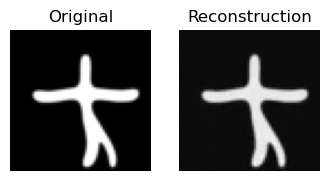

MSE  tensor(0.8956, grad_fn=<MeanBackward1>)


In [66]:
idx = 134
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0), cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0), cmap='gray')
plt.title('Reconstruction')
plt.axis('off')
plt.show()
print('MSE ', ((out.recon_x - x.data)**2).sum(dim = (1,2)).mean(dim = 0))

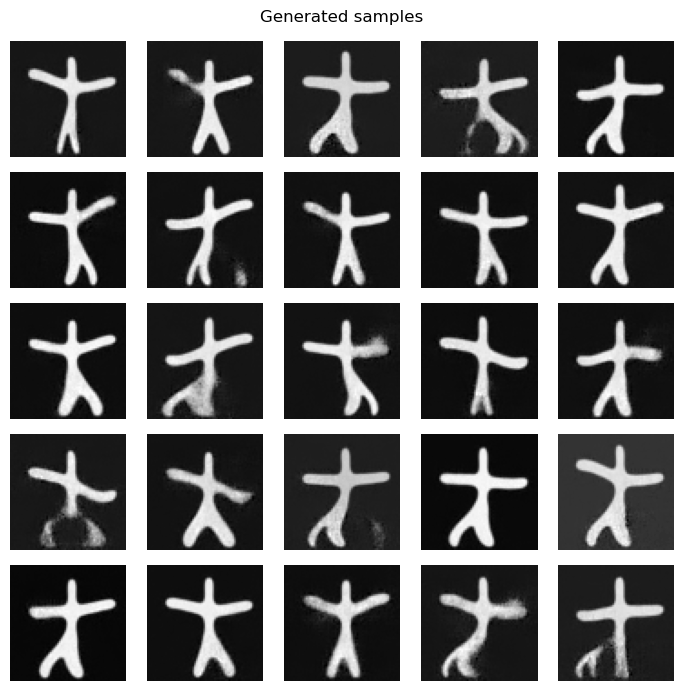

In [67]:
normal_sampler = NormalSampler(
    model=vae
)
gen_data = normal_sampler.sample(
    num_samples=25
)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7))
plt.suptitle('Generated samples')
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5+j].cpu().permute(1, 2, 0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [69]:
n_samples = 100
batch_size = 100

all_z = []

device = 'cpu'
vae = vae.to(device)
mu = mu.to(device)


for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z.append(z)

p = p[0]
all_z = torch.cat(all_z, dim=0).cpu().detach()
all_z.shape

torch.Size([100, 12])

In [70]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
all_logdet_G = []
train_embeddings = []
device = 'cpu'
vae = vae.to(device)
for i, x in enumerate(train_loader):
    x = x.to(device)
    z = vae.encoder(x).embedding
    logdet_G = vae.log_pi(z)
    all_logdet_G.append(logdet_G)
    train_embeddings.append(z)

train_embeddings = torch.cat(train_embeddings, dim=0).cpu().detach()
print(train_embeddings.shape)
all_logdet_G = torch.cat(all_logdet_G).cpu().detach().numpy()
print(all_logdet_G.shape)


torch.Size([7000, 12])
(7000,)


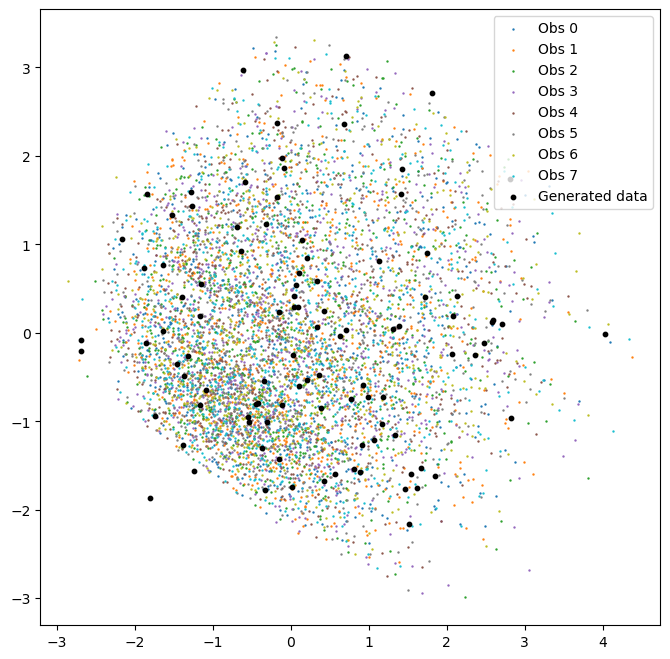

In [71]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 8
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS)
#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)
train_embeddings_pca = pca.transform(train_embeddings.detach().numpy())


plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', NUM_OBS)
for i in DISPLAYED_OBS:
    indices = [k % NUM_OBS == i for k in range(train_dataset.data.shape[0])]
    plt.scatter(train_embeddings_pca[indices, 0], train_embeddings_pca[indices, 1], s=0.5, color=colors(i), label=f'Obs {i}')

all_z_pca = pca.transform(all_z.cpu().detach().numpy())

plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data', c = 'black')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


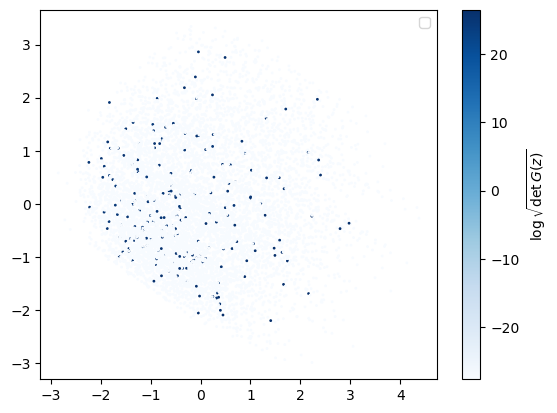

In [72]:
#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS)

#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=all_logdet_G, cmap='Blues', s=1)

plt.legend()
plt.colorbar(label=r'$ \log\sqrt{\det G(z)}$')
plt.show()

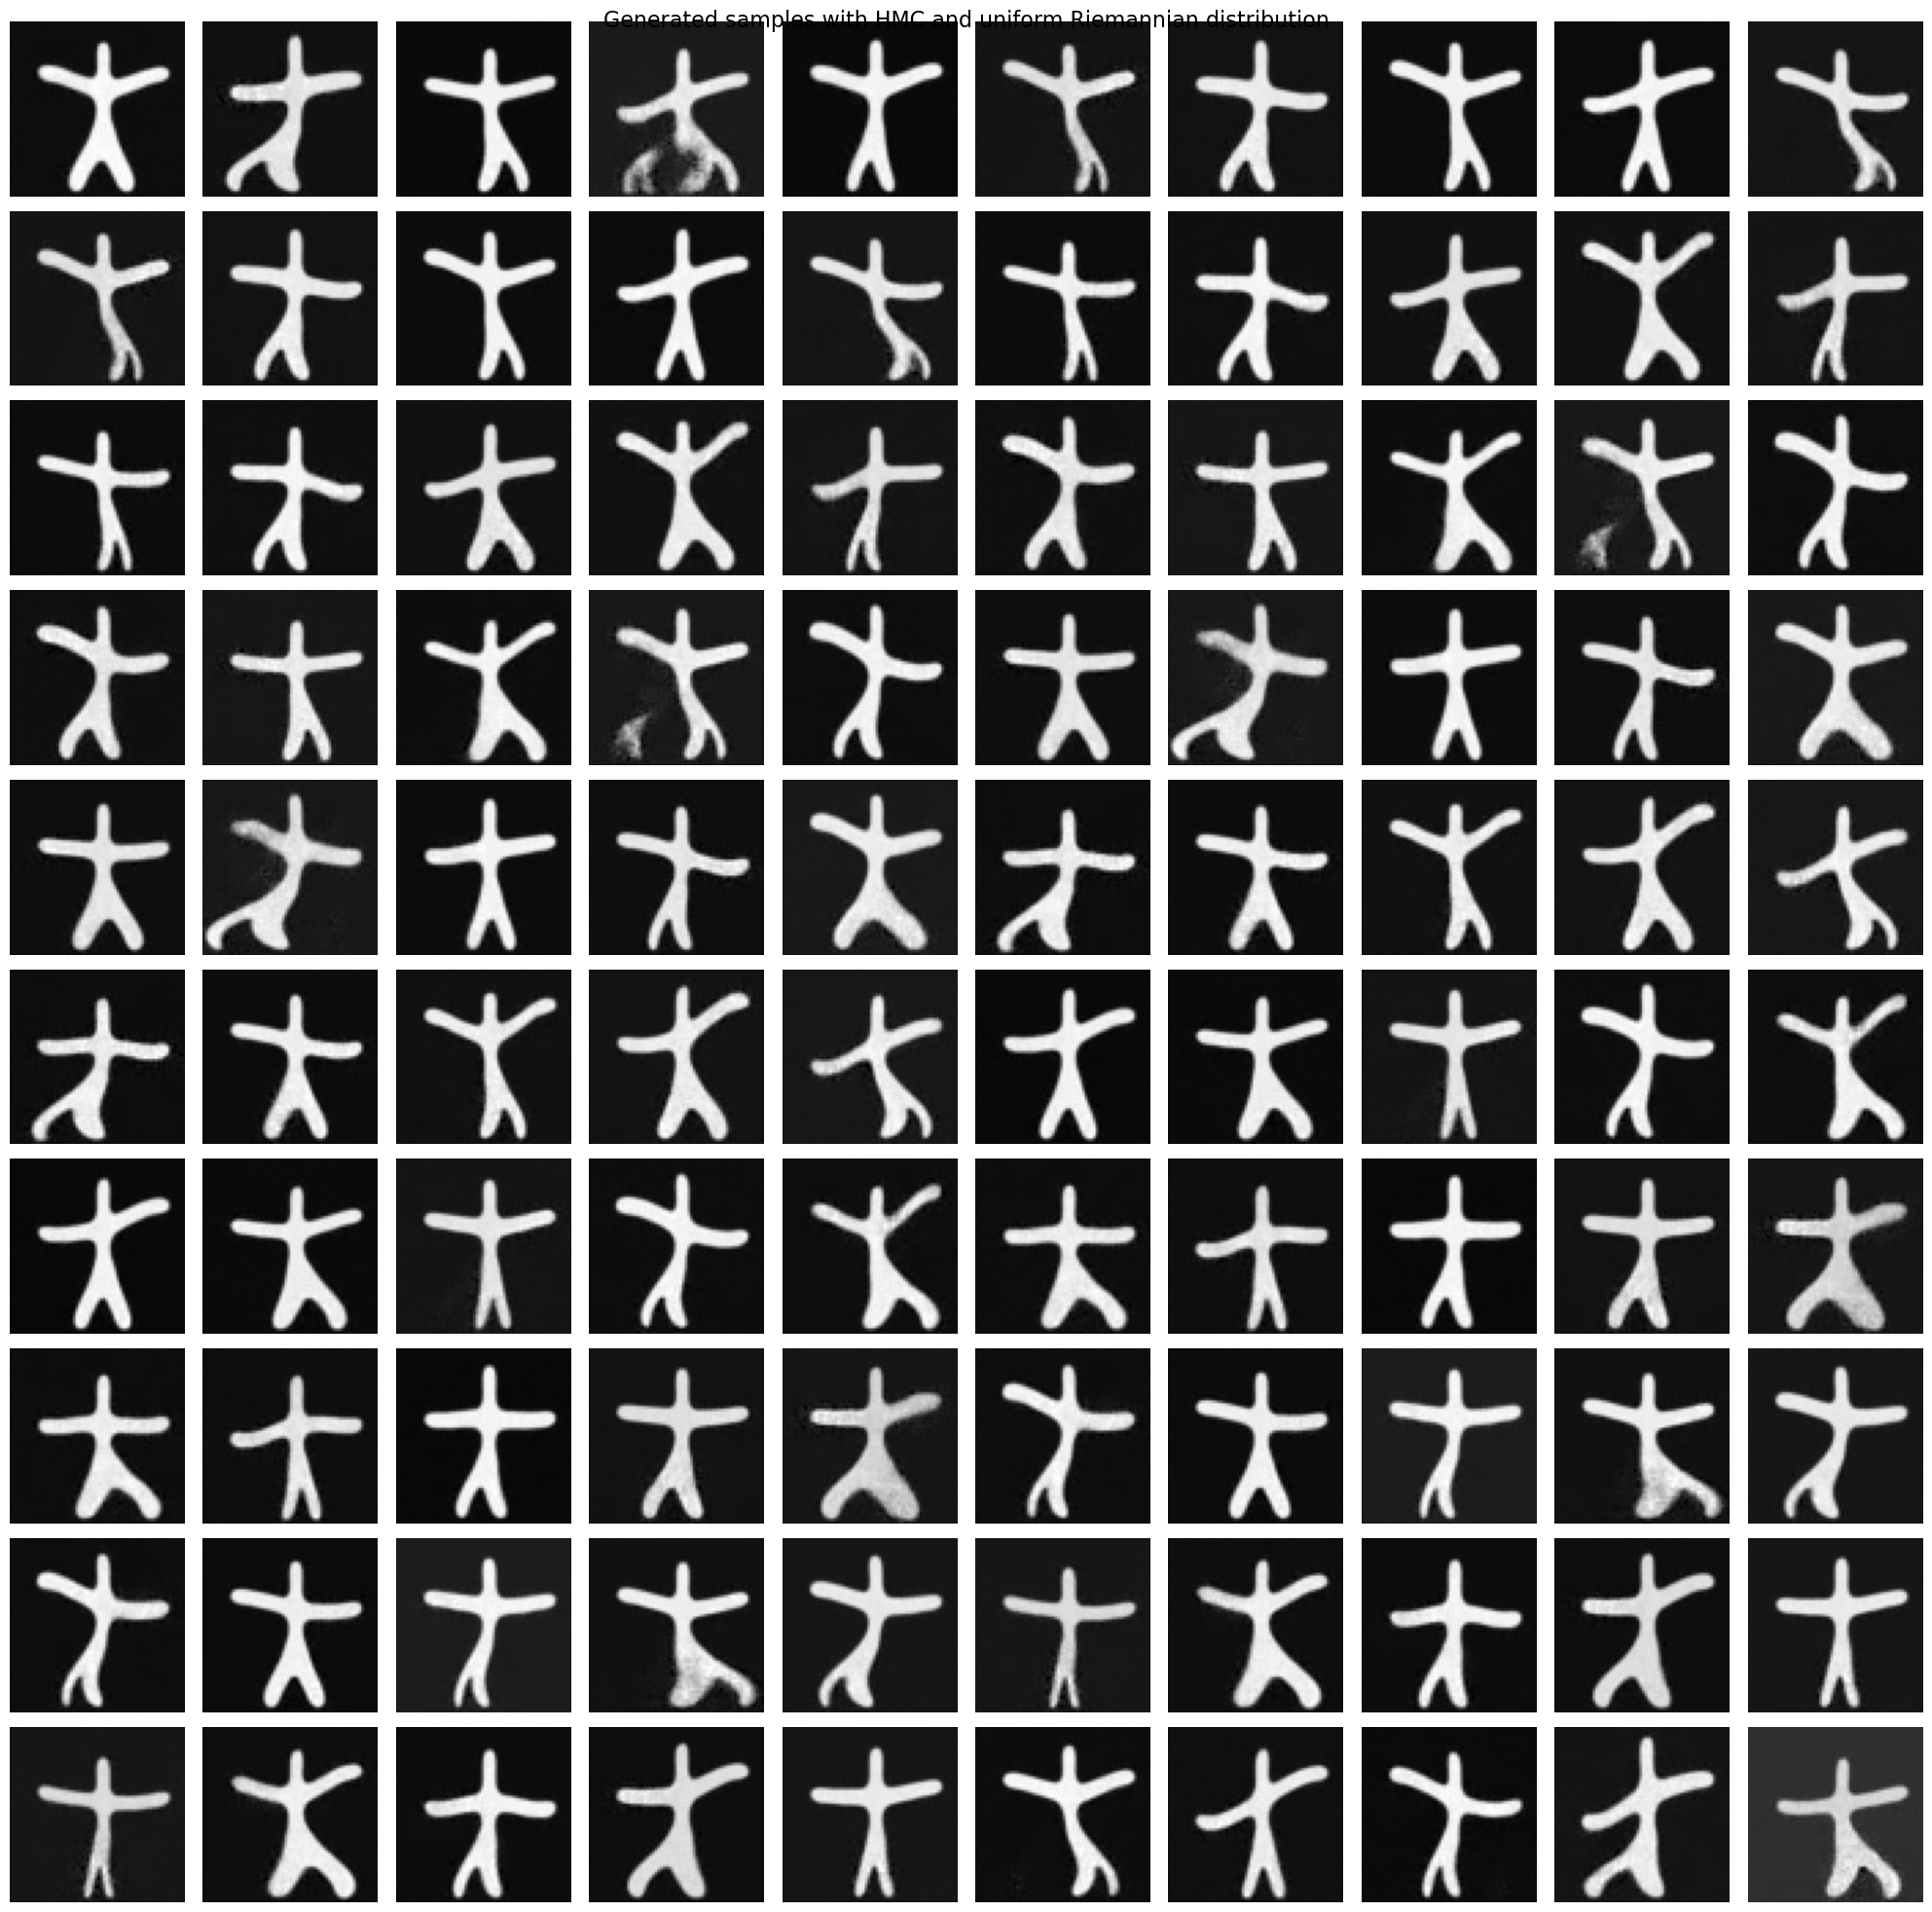

In [73]:
vae = vae.to('cpu')
all_z= all_z.to('cpu').detach()
#new_z = torch.tensor(new_z).to('cpu').detach().float()
last_obs_embeddings = train_embeddings.detach().numpy()
last_obs_embeddings = torch.tensor(last_obs_embeddings).to('cpu').detach().float()


gen_data = vae.decoder(all_z).reconstruction.detach()

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(gen_data[i*5+j].permute(1, 2, 0), cmap='gray')
        axes[i][j].axis('off')

fig.suptitle('Generated samples with HMC and uniform Riemannian distribution', fontsize=16)
plt.tight_layout()
plt.show()